## **Getting started**

This code implements the **Variational Neural Algorithm** with **2D Tensorized RNNs** to find the ground state of the **2D Edwards-Anderson** model, whose Hamiltonian is given by:
$$ H = -\sum_{\langle i,j \rangle} J_{ij} \sigma_i \sigma_{j}, $$
where the sum is over nearest-neighbors, $\sigma_i = \pm 1$ and $J_{ij}$ are random couplings uniformly sampled from $[-1,1)$.

This code is based on [RNN wave function's code](https://github.com/mhibatallah/RNNWavefunctions). Edited by Mohamed Hibat-Allah and Estelle Inack.

## **Import needed libraries**


In [ ]:
# This enforces the use of Tensorflow 1.x instead of the default Tensorflow 2.x
%tensorflow_version 1.x
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) #stop displaying tensorflow warnings
import numpy as np
import os
import time
import random
import matplotlib.pyplot as plt

#For plotting purposes
from matplotlib import rcParams

rcParams['axes.labelsize']  = 20
rcParams['font.serif']      = ['Computer Modern']
rcParams['font.size']       = 10
rcParams['legend.fontsize'] = 20
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20

TensorFlow 1.x selected.


## **Seeding for reproducibility purposes**

In [ ]:
#Seeding for reproducibility purposes
seed = 111 #seeding for reproducibility purposes
tf.compat.v1.reset_default_graph()
random.seed(seed)  # `python` built-in pseudo-random generator
np.random.seed(seed)  # numpy pseudo-random generator
tf.compat.v1.set_random_seed(seed)  # tensorflow pseudo-random generator

## **Helper Functions**

The function **Ising2D_diagonal_matrixelements** computes the diagonal matrix elements given a set of configurations **samples** and the couplings **Jz** of the 2D Edwards-Anderson model (with open-boundary conditions).

In [ ]:
# Loading Functions --------------------------
def Ising2D_diagonal_matrixelements(Jz, samples):
    """ To get the diagonal local energies of 2D spin lattice given a set of set of samples in parallel!
    Returns: The local energies that correspond to the "samples"
    Inputs:
    - samples: (numsamples, Nx,Ny)
    - Jz: (Nx,Ny,2) np array of J_ij couplings
    """

    numsamples = samples.shape[0]
    Nx = samples.shape[1]
    Ny = samples.shape[2]

    N = Nx*Ny #Total number of spins

    local_energies = np.zeros((numsamples), dtype = np.float64)

    for i in range(Nx-1): #diagonal elements (right neighbours)
        values = samples[:,i]+samples[:,i+1]
        valuesT = np.copy(values)
        valuesT[values==2] = +1 #If both spins are up
        valuesT[values==0] = +1 #If both spins are down
        valuesT[values==1] = -1 #If they are opposite

        local_energies += np.sum(valuesT*(-Jz[i,:,0]), axis = 1)

    for i in range(Ny-1): #diagonal elements (upward neighbours (or downward, it depends on the way you see the lattice :)))
        values = samples[:,:,i]+samples[:,:,i+1]
        valuesT = np.copy(values)
        valuesT[values==2] = +1 #If both spins are up
        valuesT[values==0] = +1 #If both spins are down
        valuesT[values==1] = -1 #If they are opposite

        local_energies += np.sum(valuesT*(-Jz[:,i,1]), axis = 1)

    return local_energies
#--------------------------

**Ising_local_energies** is used to compute the expectation value of the Hamiltonian over the variational state.

The 2D Edwards-Anderson Hamiltonian (with open-boundary condition), in the quantum setting, is given by
$$ \hat{H} = - \sum_{\langle i,j \rangle} J_{ij} \hat{\sigma}^{z}_i \hat{\sigma}^{z}_{j} - B_x \sum_{i=1}^{N} \hat{\sigma}^{x}_i,$$
where $\hat{\sigma}^{z}_i$ and $\hat{\sigma}^{x}_i$ are respectivelly the Pauli z and x matrices at site $i$. 
The formula for average energy over the variational state is 
$\langle \hat{H} \rangle = \langle\Psi_{\lambda}| \hat{H} |\Psi_{\lambda} \rangle = \sum_{\sigma} {|\Psi_{\lambda}(\sigma)|}^{2} E_{loc}(\sigma) $, where $E_{loc}(\sigma) = \frac{\langle \sigma | \hat{H}|\Psi_{\lambda}\rangle}{\langle \sigma |\Psi_{\lambda}\rangle}$.

In [ ]:
def Ising2D_local_energies(Jz, Bx, samples, queue_samples, log_probs_tensor, samples_placeholder, log_probs, sess):
    """ To get the local energies of 2D spin lattice given a set of set of samples in parallel!
    Returns: The local energies that correspond to the "samples"
    Inputs:
    - samples: (numsamples, Nx,Ny)
    - Jz: (Nx,Ny,2) np array of J_ij couplings
    - Bx: float
    - queue_samples: ((Nx*Ny+1)*numsamples, Nx,Ny) an allocated np array to store all the sample applying the Hamiltonian H on samples
    - log_probs_tensor: A TF tensor with size (None)
    - samples_placeholder: A TF placeholder to feed in a set of configurations
    - log_probs: ((Nx*Ny+1)*numsamples): an allocated np array to store the log_probs non diagonal elements
    - sess: The current TF session
    """

    numsamples = samples.shape[0]
    Nx = samples.shape[1]
    Ny = samples.shape[2]

    N = Nx*Ny #Total number of spins

    local_energies = np.zeros((numsamples), dtype = np.float64)

    for i in range(Nx-1): #diagonal elements (right neighbours)
        values = samples[:,i]+samples[:,i+1]
        valuesT = np.copy(values)
        valuesT[values==2] = +1 #If both spins are up
        valuesT[values==0] = +1 #If both spins are down
        valuesT[values==1] = -1 #If they are opposite

        local_energies += np.sum(valuesT*(-Jz[i,:,0]), axis = 1)

    for i in range(Ny-1): #diagonal elements (upward neighbours (or downward, it depends on the way you see the lattice :)))
        values = samples[:,:,i]+samples[:,:,i+1]
        valuesT = np.copy(values)
        valuesT[values==2] = +1 #If both spins are up
        valuesT[values==0] = +1 #If both spins are down
        valuesT[values==1] = -1 #If they are opposite

        local_energies += np.sum(valuesT*(-Jz[:,i,1]), axis = 1)


    queue_samples[0] = samples #storing the diagonal samples

    if Bx != 0:
        for i in range(Nx):  #Non-diagonal elements
            for j in range(Ny):
                valuesT = np.copy(samples)
                valuesT[:,i,j][samples[:,i,j]==1] = 0 #Flip
                valuesT[:,i,j][samples[:,i,j]==0] = 1 #Flip

                queue_samples[i*Ny+j+1] = valuesT

        len_sigmas = (N+1)*numsamples
        steps = len_sigmas//50000+1 #I want a maximum in batch size just to not allocate too much memory
        # print("Total num of steps =", steps)
        queue_samples_reshaped = np.reshape(queue_samples, [(N+1)*numsamples, Nx,Ny])
        for i in range(steps):
          if i < steps-1:
              cut = slice((i*len_sigmas)//steps,((i+1)*len_sigmas)//steps)
          else:
              cut = slice((i*len_sigmas)//steps,len_sigmas)
          log_probs[cut] = sess.run(log_probs_tensor, feed_dict={samples_placeholder:queue_samples_reshaped[cut]})
          # print(i)

        log_probs_reshaped = np.reshape(log_probs, [N+1,numsamples])
        for j in range(numsamples):
            local_energies[j] += -Bx*np.sum(np.exp(0.5*log_probs_reshaped[1:,j]-0.5*log_probs_reshaped[0,j]))

    return local_energies

In our code, we need to use a tensordot operation to define our tensorized RNN. For speed purposes, we use a modified version of TensorFlow's tensordot operation, which is faster the one implemented in Tensorflow, and that is taken from the TensorNetwork package https://github.com/google/TensorNetwork


In [ ]:
# Copyright 2019 The TensorNetwork Authors

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""A modified version of TensorFlow's tensordot operation."""

from typing import Any, Optional, Union, Text, Sequence, Tuple, List

Tensor = Any


def tensordot(tf,
              a,
              b,
              axes,
              name: Optional[Text] = None) -> Tensor:
  r"""Tensor contraction of a and b along specified axes.
  Tensordot (also known as tensor contraction) sums the product of elements
  from `a` and `b` over the indices specified by `a_axes` and `b_axes`.
  The lists `a_axes` and `b_axes` specify those pairs of axes along which to
  contract the tensors. The axis `a_axes[i]` of `a` must have the same dimension
  as axis `b_axes[i]` of `b` for all `i` in `range(0, len(a_axes))`. The lists
  `a_axes` and `b_axes` must have identical length and consist of unique
  integers that specify valid axes for each of the tensors.
  This operation corresponds to `numpy.tensordot(a, b, axes)`.
  Example 1: When `a` and `b` are matrices (order 2), the case `axes = 1`
  is equivalent to matrix multiplication.
  Example 2: When `a` and `b` are matrices (order 2), the case
  `axes = [[1], [0]]` is equivalent to matrix multiplication.
  Example 3: Suppose that \\(a_{ijk}\\) and \\(b_{lmn}\\) represent two
  tensors of order 3. Then, `contract(a, b, [[0], [2]])` is the order 4 tensor
  \\(c_{jklm}\\) whose entry
  corresponding to the indices \\((j,k,l,m)\\) is given by:
  \\( c_{jklm} = \sum_i a_{ijk} b_{lmi} \\).
  In general, `order(c) = order(a) + order(b) - 2*len(axes[0])`.
  Args:
    tf: The TensorFlow module. This must be passed in instead of imported
      since we don't assume users have TensorFlow installed.
    a: `Tensor` of type `float32` or `float64`.
    b: `Tensor` with the same type as `a`.
    axes: Either a scalar `N`, or a list or an `int32` `Tensor` of shape [2, k].
      If axes is a scalar, sum over the last N axes of a and the first N axes of
      b in order. If axes is a list or `Tensor` the first and second row contain
      the set of unique integers specifying axes along which the contraction is
      computed, for `a` and `b`, respectively. The number of axes for `a` and
      `b` must be equal.
    name: A name for the operation (optional).
  Returns:
    A `Tensor` with the same type as `a`.
  Raises:
    ValueError: If the shapes of `a`, `b`, and `axes` are incompatible.
    IndexError: If the values in axes exceed the rank of the corresponding
      tensor.
  """

  def _tensordot_should_flip(contraction_axes: List[int],
                              free_axes: List[int]) -> bool:
    """Helper method to determine axis ordering.
    We minimize the average distance the indices would have to move under the
    transposition.
    Args:
      contraction_axes: The axes to be contracted.
      free_axes: The free axes.
    Returns:
      should_flip: `True` if `contraction_axes` should be moved to the left,
        `False` if they should be moved to the right.
    """
    # NOTE: This will fail if the arguments contain any Tensors.
    if contraction_axes and free_axes:
      return bool(np.mean(contraction_axes) < np.mean(free_axes))

    return False

  def _tranpose_if_necessary(tensor: Tensor, perm: List[int]) -> Tensor:
    """Like transpose(), but avoids creating a new tensor if possible.
    Although the graph optimizer should kill trivial transposes, it is best not
    to add them in the first place!
    """
    if perm == list(range(len(perm))):
      return tensor

    return tf.transpose(tensor, perm)

  def _reshape_if_necessary(tensor: Tensor,
                            new_shape: List[int]) -> Tensor:
    """Like reshape(), but avoids creating a new tensor if possible.
    Assumes shapes are both fully specified."""
    cur_shape = tensor.get_shape().as_list()
    if (len(new_shape) == len(cur_shape) and
        all(d0 == d1 for d0, d1 in zip(cur_shape, new_shape))):
      return tensor

    return tf.reshape(tensor, new_shape)

  def _tensordot_reshape(
      a: Tensor, axes: Union[Sequence[int], Tensor], is_right_term=False
  ) -> Tuple[Tensor, Union[List[int], Tensor], Optional[List[int]], bool]:
    """Helper method to perform transpose and reshape for contraction op.
    This method is helpful in reducing `math_ops.tensordot` to `math_ops.matmul`
    using `array_ops.transpose` and `array_ops.reshape`. The method takes a
    tensor and performs the correct transpose and reshape operation for a given
    set of indices. It returns the reshaped tensor as well as a list of indices
    necessary to reshape the tensor again after matrix multiplication.
    Args:
      a: `Tensor`.
      axes: List or `int32` `Tensor` of unique indices specifying valid axes of
       `a`.
      is_right_term: Whether `a` is the right (second) argument to `matmul`.
    Returns:
      A tuple `(reshaped_a, free_dims, free_dims_static, transpose_needed)`
      where `reshaped_a` is the tensor `a` reshaped to allow contraction via
      `matmul`, `free_dims` is either a list of integers or an `int32`
      `Tensor`, depending on whether the shape of a is fully specified, and
      free_dims_static is either a list of integers and None values, or None,
      representing the inferred static shape of the free dimensions.
      `transpose_needed` indicates whether `reshaped_a` must be transposed,
      or not, when calling `matmul`.
    """

    if a.get_shape().is_fully_defined() and isinstance(axes, (list, tuple)):
      shape_a = a.get_shape().as_list()
      # NOTE: This will fail if axes contains any tensors
      axes = [i if i >= 0 else i + len(shape_a) for i in axes]
      free = [i for i in range(len(shape_a)) if i not in axes]
      flipped = _tensordot_should_flip(axes, free)

      free_dims = [shape_a[i] for i in free]
      prod_free = int(np.prod([shape_a[i] for i in free]))
      prod_axes = int(np.prod([shape_a[i] for i in axes]))
      perm = axes + free if flipped else free + axes
      new_shape = [prod_axes, prod_free] if flipped else [prod_free, prod_axes]
      transposed_a = _tranpose_if_necessary(a, perm)
      reshaped_a = _reshape_if_necessary(transposed_a, new_shape)
      transpose_needed = (not flipped) if is_right_term else flipped
      return reshaped_a, free_dims, free_dims, transpose_needed

    if a.get_shape().ndims is not None and isinstance(axes, (list, tuple)):
      shape_a = a.get_shape().as_list()
      axes = [i if i >= 0 else i + len(shape_a) for i in axes]
      free = [i for i in range(len(shape_a)) if i not in axes]
      flipped = _tensordot_should_flip(axes, free)
      perm = axes + free if flipped else free + axes

      axes_dims = [shape_a[i] for i in axes]
      free_dims = [shape_a[i] for i in free]
      free_dims_static = free_dims
      axes = tf.convert_to_tensor(axes, dtype=tf.dtypes.int32, name="axes")
      free = tf.convert_to_tensor(free, dtype=tf.dtypes.int32, name="free")
      shape_a = tf.shape(a)
      transposed_a = _tranpose_if_necessary(a, perm)
    else:
      free_dims_static = None
      shape_a = tf.shape(a)
      rank_a = tf.rank(a)
      axes = tf.convert_to_tensor(axes, dtype=tf.dtypes.int32, name="axes")
      axes = tf.where(axes >= 0, axes, axes + rank_a)
      free, _ = tf.compat.v1.setdiff1d(tf.range(rank_a), axes)
      # Matmul does not accept tensors for its transpose arguments, so fall
      # back to the previous, fixed behavior.
      # NOTE(amilsted): With a suitable wrapper for `matmul` using e.g. `case`
      #   to match transpose arguments to tensor values, we could also avoid
      #   unneeded tranposes in this case at the expense of a somewhat more
      #   complicated graph. Unclear whether this would be beneficial overall.
      flipped = is_right_term
      perm = (
          tf.concat([axes, free], 0) if flipped else tf.concat([free, axes], 0))
      transposed_a = tf.transpose(a, perm)

    free_dims = tf.gather(shape_a, free)
    axes_dims = tf.gather(shape_a, axes)
    prod_free_dims = tf.reduce_prod(free_dims)
    prod_axes_dims = tf.reduce_prod(axes_dims)

    if flipped:
      new_shape = tf.stack([prod_axes_dims, prod_free_dims])
    else:
      new_shape = tf.stack([prod_free_dims, prod_axes_dims])
    reshaped_a = tf.reshape(transposed_a, new_shape)
    transpose_needed = (not flipped) if is_right_term else flipped

    return reshaped_a, free_dims, free_dims_static, transpose_needed

  def _tensordot_axes(a: Tensor, axes) -> Tuple[Any, Any]:
      """Generates two sets of contraction axes for the two tensor arguments."""
      a_shape = a.get_shape()
      if isinstance(axes, tf.compat.integral_types):
        if axes < 0:
          raise ValueError("'axes' must be at least 0.")
        if a_shape.ndims is not None:
          if axes > a_shape.ndims:
            raise ValueError("'axes' must not be larger than the number of "
                            "dimensions of tensor %s." % a)
          return (list(range(a_shape.ndims - axes,
                            a_shape.ndims)), list(range(axes)))
        rank = tf.rank(a)
        return (tf.range(rank - axes, rank,
                        dtype=tf.int32), tf.range(axes, dtype=tf.int32))
      if isinstance(axes, (list, tuple)):
        if len(axes) != 2:
          raise ValueError("'axes' must be an integer or have length 2.")
        a_axes = axes[0]
        b_axes = axes[1]
        if isinstance(a_axes, tf.compat.integral_types) and \
            isinstance(b_axes, tf.compat.integral_types):
          a_axes = [a_axes]
          b_axes = [b_axes]
        # NOTE: This fails if either a_axes and b_axes are Tensors.
        if len(a_axes) != len(b_axes):
          raise ValueError(
              "Different number of contraction axes 'a' and 'b', %s != %s." %
              (len(a_axes), len(b_axes)))

        # The contraction indices do not need to be permuted.
        # Sort axes to avoid unnecessary permutations of a.
        # NOTE: This fails if either a_axes and b_axes contain Tensors.
        # pylint: disable=len-as-condition
        if len(a_axes) > 0:
          a_axes, b_axes = list(zip(*sorted(zip(a_axes, b_axes))))

        return a_axes, b_axes

      axes = tf.convert_to_tensor(axes, name="axes", dtype=tf.int32)
      return axes[0], axes[1]

  with tf.compat.v1.name_scope(name, "Tensordot", [a, b, axes]) as _name:
    a = tf.convert_to_tensor(a, name="a")
    b = tf.convert_to_tensor(b, name="b")
    a_axes, b_axes = _tensordot_axes(a, axes)
    a_reshape, a_free_dims, a_free_dims_static, a_transp = _tensordot_reshape(
        a, a_axes)
    b_reshape, b_free_dims, b_free_dims_static, b_transp = _tensordot_reshape(
        b, b_axes, is_right_term=True)

    ab_matmul = tf.matmul(
        a_reshape, b_reshape, transpose_a=a_transp, transpose_b=b_transp)

    if isinstance(a_free_dims, list) and isinstance(b_free_dims, list):
      return tf.reshape(ab_matmul, a_free_dims + b_free_dims, name=_name)
    a_free_dims = tf.convert_to_tensor(a_free_dims, dtype=tf.dtypes.int32)
    b_free_dims = tf.convert_to_tensor(b_free_dims, dtype=tf.dtypes.int32)
    product = tf.reshape(
        ab_matmul, tf.concat([a_free_dims, b_free_dims], 0), name=_name)
    if a_free_dims_static is not None and b_free_dims_static is not None:
      product.set_shape(a_free_dims_static + b_free_dims_static)
      
    return product
                   

## **2D Tensorised RNN Cell**

To do variational annealing on the 2D Edwards-Anderson model, we use 1D Tensorized RNNs. The recurrent step for the Tensorized RNN is instead given by:

$${h}_{ij} = f\left([{\sigma}^{ \intercal }_{i-1,j};{\sigma}^{ \intercal }_{i,j-1}] T_{ij} [h_{i-1,j};h_{i,j-1}] + {b}_{ij} \right),$$
where $\{T_{ij}\}_{i=1,j=1}^{N_x,Ny}$ are site-dependent tensors that encode non-weight sharing, to take account of the randomness in the couplings $J_{ij}$ of the Edwards-Anderson model.

In [ ]:
class MDTensorizedRNNCell(tf.contrib.rnn.RNNCell):
    """The 2D Tensorized RNN cell.
    """
    def __init__(self, num_units = None, activation = None, name=None, dtype = None, reuse=None):
        super(MDTensorizedRNNCell, self).__init__(_reuse=reuse, name=name)
        # save class variables
        self._num_in = 2
        self._num_units = num_units
        self._state_size = num_units
        self._output_size = num_units
        self.activation = activation

        # set up input -> hidden connection
        self.W = tf.get_variable("W_"+name, shape=[num_units, 2*num_units, 2*self._num_in],
                                    initializer=tf.contrib.layers.xavier_initializer(), dtype = dtype)

        self.b = tf.get_variable("b_"+name, shape=[num_units],
                                    initializer=tf.contrib.layers.xavier_initializer(), dtype = dtype)

    # needed properties

    @property
    def input_size(self):
        return self._num_in # real

    @property
    def state_size(self):
        return self._state_size # real

    @property
    def output_size(self):
        return self._output_size # real

    def call(self, inputs, states):

        inputstate_mul = tf.einsum('ij,ik->ijk', tf.concat(states, 1),tf.concat(inputs,1))
        # prepare input linear combination
        state_mul = tensordot(tf, inputstate_mul, self.W, axes=[[1,2],[1,2]]) # [batch_sz, num_units]

        preact = state_mul + self.b

        output = self.activation(preact) # [batch_sz, num_units] C

        new_state = output

        return output, new_state


## **RNN Wavefunction Class**

Here, we define the 2D RNNwavefunction class, which contains the **sample** method that allows to sample configurations autoregressively from the RNN and the **log_probability** method which allows to estimate the log-probability of a set of configurations.

Note that the log probabilities $\log P_{\lambda}(\sigma)$ are used here because we assume that the ground state wavefunction has non-negative amplitudes. Thus, we can write $\Psi_{\lambda}(\sigma) = \sqrt{P_{\lambda}(\sigma)}$, where $\lambda$ stands for the variational parameters.

The equation **rnn_output, rnn_state = self.rnn(inputs, rnn_state)** performs the recurrent step.

Here we use a zigzag path to generate the 2D samples as explained in https://arxiv.org/abs/2002.02973 and https://arxiv.org/abs/2101.10154.


In [ ]:
class MDRNNWavefunction(object):
    def __init__(self,systemsize_x = None, systemsize_y = None,cell=None,activation=None,num_units = None,scope='RNNWavefunction',seed = 111):
        """
            systemsize_x, systemsize_y:  int
                         number of sites in x, y directions
            cell:        a tensorflow RNN cell
            num_units:   int
                         number of memory units
            scope:       str
                         the name of the name-space scope
            activation:  activation of the RNN cell
            seed:        pseudo-random number generator
        """
        self.graph=tf.Graph()
        self.scope=scope #Label of the RNN wavefunction
        self.Nx=systemsize_x 
        self.Ny=systemsize_y

        random.seed(seed)  # `python` built-in pseudo-random generator
        np.random.seed(seed)  # numpy pseudo-random generator

        #Defining the neural network
        with self.graph.as_default():
            with tf.variable_scope(self.scope,reuse=tf.AUTO_REUSE):

              tf.set_random_seed(seed)  # tensorflow pseudo-random generator

              #Defining the 2D Tensorized RNN cell with non-weight sharing
              self.rnn=[cell(num_units = num_units, activation = activation, name="rnn_"+str(0)+str(i),dtype=tf.float64) for i in range(self.Nx*self.Ny)]
              self.dense = [tf.layers.Dense(2,activation=tf.nn.softmax,name='wf_dense'+str(i), dtype = tf.float64) for i in range(self.Nx*self.Ny)]

    def sample(self,numsamples,inputdim):
        """
            generate samples from a probability distribution parametrized by a recurrent network
            ------------------------------------------------------------------------
            Parameters:

            numsamples:      int
                             number of samples to be produced
            inputdim:        int
                             hilbert space dimension

            ------------------------------------------------------------------------
            Returns:         a tuple (samples,log-probs)

            samples:         tf.Tensor of shape (numsamples,systemsize_x, systemsize_y)
                             the samples in integer encoding
            log-probs        tf.Tensor of shape (numsamples,)
                             the log-probability of each sample
        """

        with self.graph.as_default(): #Call the default graph, used if willing to create multiple graphs.
            with tf.variable_scope(self.scope,reuse=tf.AUTO_REUSE):

                #Initial input to feed to the lstm

                self.inputdim=inputdim
                self.outputdim=self.inputdim
                self.numsamples=numsamples


                samples=[[[] for nx in range(self.Nx)] for ny in range(self.Ny)]
                probs = [[[] for nx in range(self.Nx)] for ny in range(self.Ny)]
                rnn_states = {}
                inputs = {}

                for ny in range(self.Ny): #Loop over the boundaries for initialization
                    if ny%2==0:
                        nx = -1
                        # print(nx,ny)
                        rnn_states[str(nx)+str(ny)]=self.rnn[0].zero_state(self.numsamples,dtype=tf.float64)
                        inputs[str(nx)+str(ny)] = tf.zeros((self.numsamples,inputdim), dtype = tf.float64) #Feed the table b in tf.

                    if ny%2==1:
                        nx = self.Nx
                        # print(nx,ny)
                        rnn_states[str(nx)+str(ny)]=self.rnn[0].zero_state(self.numsamples,dtype=tf.float64)
                        inputs[str(nx)+str(ny)] = tf.zeros((self.numsamples,inputdim), dtype = tf.float64) #Feed the table b in tf.


                for nx in range(self.Nx): #Loop over the boundaries for initialization
                    ny = -1
                    rnn_states[str(nx)+str(ny)]=self.rnn[0].zero_state(self.numsamples,dtype=tf.float64)
                    inputs[str(nx)+str(ny)] = tf.zeros((self.numsamples,inputdim), dtype = tf.float64) #Feed the table b in tf.

                #Making a loop over the sites with the 2DRNN
                for ny in range(self.Ny): 

                    if ny%2 == 0:

                        for nx in range(self.Nx): #left to right

                            rnn_output, rnn_states[str(nx)+str(ny)] = self.rnn[ny*self.Nx+nx]((inputs[str(nx-1)+str(ny)],inputs[str(nx)+str(ny-1)]), (rnn_states[str(nx-1)+str(ny)],rnn_states[str(nx)+str(ny-1)]))

                            output=self.dense[ny*self.Nx+nx](rnn_output)
                            sample_temp=tf.reshape(tf.multinomial(tf.log(output),num_samples=1),[-1,])
                            samples[nx][ny] = sample_temp
                            probs[nx][ny] = output
                            inputs[str(nx)+str(ny)]=tf.one_hot(sample_temp,depth=self.outputdim, dtype = tf.float64)


                    if ny%2 == 1:

                        for nx in range(self.Nx-1,-1,-1): #right to left

                            rnn_output, rnn_states[str(nx)+str(ny)] = self.rnn[ny*self.Nx+nx]((inputs[str(nx+1)+str(ny)],inputs[str(nx)+str(ny-1)]), (rnn_states[str(nx+1)+str(ny)],rnn_states[str(nx)+str(ny-1)]))

                            output=self.dense[ny*self.Nx+nx](rnn_output)
                            sample_temp=tf.reshape(tf.multinomial(tf.log(output),num_samples=1),[-1,])
                            samples[nx][ny] = sample_temp
                            probs[nx][ny] = output
                            inputs[str(nx)+str(ny)]=tf.one_hot(sample_temp,depth=self.outputdim, dtype = tf.float64)


        self.samples=tf.transpose(tf.stack(values=samples,axis=0), perm = [2,0,1])

        probs=tf.transpose(tf.stack(values=probs,axis=0),perm=[2,0,1,3])
        one_hot_samples=tf.one_hot(self.samples,depth=self.inputdim, dtype = tf.float64)
        self.log_probs=tf.reduce_sum(tf.reduce_sum(tf.log(tf.reduce_sum(tf.multiply(probs,one_hot_samples),axis=3)),axis=2),axis=1)


        return self.samples,self.log_probs


    def log_probability(self,samples,inputdim):
        """
            calculate the log-probabilities of ```samples``
            ------------------------------------------------------------------------
            Parameters:

            samples:         tf.Tensor
                             a tf.placeholder of shape (number of samples,systemsize_x, systemsize_y)
                             containing the input samples in integer encoding
            inputdim:        int
                             dimension of the input space

            ------------------------------------------------------------------------
            Returns:
            log-probs        tf.Tensor of shape (number of samples,)
                             the log-probability of each sample
            """
        with self.graph.as_default():

            self.inputdim=inputdim
            self.outputdim=self.inputdim

            self.numsamples=tf.shape(samples)[0]

            #Initial input to feed to the lstm
            self.outputdim=self.inputdim


            samples_=tf.transpose(samples, perm = [1,2,0])
            rnn_states = {}
            inputs = {}

            for ny in range(self.Ny): #Loop over the boundaries for initialization
                if ny%2==0:
                    nx = -1
                    rnn_states[str(nx)+str(ny)]=self.rnn[0].zero_state(self.numsamples,dtype=tf.float64)
                    inputs[str(nx)+str(ny)] = tf.zeros((self.numsamples,inputdim), dtype = tf.float64) #Feed the table b in tf.

                if ny%2==1:
                    nx = self.Nx
                    rnn_states[str(nx)+str(ny)]=self.rnn[0].zero_state(self.numsamples,dtype=tf.float64)
                    inputs[str(nx)+str(ny)] = tf.zeros((self.numsamples,inputdim), dtype = tf.float64) #Feed the table b in tf.


            for nx in range(self.Nx): #Loop over the boundaries for initialization
                ny = -1
                rnn_states[str(nx)+str(ny)]=self.rnn[0].zero_state(self.numsamples,dtype=tf.float64)
                inputs[str(nx)+str(ny)] = tf.zeros((self.numsamples,inputdim), dtype = tf.float64) #Feed the table b in tf.


            with tf.variable_scope(self.scope,reuse=tf.AUTO_REUSE):
                probs = [[[] for nx in range(self.Nx)] for ny in range(self.Ny)]

                #Making a loop over the sites with the 2DRNN
                for ny in range(self.Ny):

                    if ny%2 == 0:

                        for nx in range(self.Nx): #left to right

                            rnn_output, rnn_states[str(nx)+str(ny)] = self.rnn[ny*self.Nx+nx]((inputs[str(nx-1)+str(ny)],inputs[str(nx)+str(ny-1)]), (rnn_states[str(nx-1)+str(ny)],rnn_states[str(nx)+str(ny-1)]))

                            output=self.dense[ny*self.Nx+nx](rnn_output)
                            sample_temp=tf.reshape(tf.multinomial(tf.log(output),num_samples=1),[-1,])
                            probs[nx][ny] = output
                            inputs[str(nx)+str(ny)]=tf.one_hot(samples_[nx,ny],depth=self.outputdim,dtype = tf.float64)

                    if ny%2 == 1:

                        for nx in range(self.Nx-1,-1,-1): #right to left

                            rnn_output, rnn_states[str(nx)+str(ny)] = self.rnn[ny*self.Nx+nx]((inputs[str(nx+1)+str(ny)],inputs[str(nx)+str(ny-1)]), (rnn_states[str(nx+1)+str(ny)],rnn_states[str(nx)+str(ny-1)]))

                            output=self.dense[ny*self.Nx+nx](rnn_output)
                            sample_temp=tf.reshape(tf.multinomial(tf.log(output),num_samples=1),[-1,])
                            probs[nx][ny] = output
                            inputs[str(nx)+str(ny)]=tf.one_hot(samples_[nx,ny],depth=self.outputdim,dtype = tf.float64)

            probs=tf.transpose(tf.stack(values=probs,axis=0),perm=[2,0,1,3])
            one_hot_samples=tf.one_hot(samples,depth=self.inputdim, dtype = tf.float64)

            self.log_probs=tf.reduce_sum(tf.reduce_sum(tf.log(tf.reduce_sum(tf.multiply(probs,one_hot_samples),axis=3)),axis=2),axis=1)

            return self.log_probs

## **Hyperparameters**

Here we define the hyperparameters used in our variational annealing protocol.

**Note:**

If $B_{x0} = 0$, then this code will run Variational Classical Annealing (VCA).

If $T_0 = 0$, then this code will run Variational Quantum Annealing (VQA).

If both are zero, then this algorithm will correspond to classical quantum optimization (CQO).

For more details, please check Ref. https://arxiv.org/abs/2101.10154.

In [ ]:
Nx = 5 #x-size
Ny = 5 #y-size
N = Nx*Ny #total number of sites
num_units = 20 #number of memory units
numsamples = 50 #number of samples used for training
lr = 1e-4 #learning rate
T0 = 2 #Initial temperature
Bx0 = 2 #Initial magnetic field
num_warmup_steps = 1000 #number of warmup steps
num_annealing_steps = 500 #number of annealing steps
num_equilibrium_steps = 5 #number of training steps after each annealing step
activation_function = tf.nn.elu #non-linear activation function for the 2D Tensorized RNN cell

Jz = +np.random.uniform(0,2, size = (Nx,Ny,2))-1 #Couplings of Edwards-Anderson model

print('\n')
print("Number of spins =", N)
print("Initial_temperature =", T0)
print('Seed = ', seed)

num_steps = num_annealing_steps*num_equilibrium_steps + num_warmup_steps

print("\nNumber of annealing steps = {0}".format(num_annealing_steps))
print("Number of training steps = {0}".format(num_steps))




Number of spins = 25
Initial_temperature = 2
Seed =  111

Number of annealing steps = 500
Number of training steps = 3500


## **Initializing and Building the Graph**

Here we define the 2D RNNWavefunction class, along with the optimizer, gradients and placeholders needed for the optimization of the RNN.

In [ ]:
# Intitializing the RNN (with only one layer)-----------
MDRNNWF = MDRNNWavefunction(systemsize_x = Nx, systemsize_y = Ny ,num_units = num_units,cell=MDTensorizedRNNCell, activation = activation_function, seed = seed) #contains the graph with the RNNs

In [ ]:

#Building the graph -------------------
with tf.compat.v1.variable_scope(MDRNNWF.scope,reuse=tf.compat.v1.AUTO_REUSE):
    with MDRNNWF.graph.as_default():

        global_step = tf.Variable(0, trainable=False)
        learningrate_placeholder = tf.compat.v1.placeholder(dtype=tf.float64,shape=[])
        learningrate = tf.compat.v1.train.exponential_decay(learningrate_placeholder, global_step, 100, 1.0, staircase=True)
      
        #Defining the optimizer
        optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=learningrate)

        #Defining Tensorflow placeholders
        Eloc=tf.compat.v1.placeholder(dtype=tf.float64,shape=[numsamples])
        sampleplaceholder_forgrad=tf.compat.v1.placeholder(dtype=tf.int32,shape=[numsamples,Nx,Ny])
        log_probs_forgrad = MDRNNWF.log_probability(sampleplaceholder_forgrad,inputdim=2)

        samples_placeholder=tf.compat.v1.placeholder(dtype=tf.int32,shape=(None,Nx, Ny))
        log_probs_tensor=MDRNNWF.log_probability(samples_placeholder,inputdim=2)
        samplesandprobs = MDRNNWF.sample(numsamples=numsamples,inputdim=2)

        T_placeholder = tf.compat.v1.placeholder(dtype=tf.float64,shape=())

        #Here we define a fake cost function that would allows to get the gradients of free energy using the tf.stop_gradient trick
        Floc = Eloc + T_placeholder*log_probs_forgrad
        cost = tf.reduce_mean(tf.multiply(log_probs_forgrad,tf.stop_gradient(Floc))) - tf.reduce_mean(log_probs_forgrad)*tf.reduce_mean(tf.stop_gradient(Floc))

        gradients, variables = zip(*optimizer.compute_gradients(cost))
        #Calculate Gradients---------------


        #Define the optimization step
        optstep=optimizer.apply_gradients(zip(gradients,variables), global_step = global_step)
 
         #Tensorflow saver to checkpoint
        saver=tf.compat.v1.train.Saver()

        #For initialization
        init=tf.compat.v1.global_variables_initializer()
        initialize_parameters = tf.initialize_all_variables()
#----------------------------------------------------------------


Here we initialize the tensorflow session:

In [ ]:
#Starting Session------------
#GPU management
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

sess=tf.compat.v1.Session(graph=MDRNNWF.graph, config=config)
sess.run(init)

#Loading previous trainings----------
    ### To be implemented
#------------------------------------

## **Running variational annealing**

In this part of the code, we implement our variational annealing protocol.

Here, we follow a linear schedule for temperature:

$$ T(t) = T_0 (1-t/N_{\rm annealing}) $$
and for transverse magnetic field:
$$ B_x(t) = B_{x0} (1-t/N_{\rm annealing}) $$

In [ ]:
with tf.compat.v1.variable_scope(MDRNNWF.scope,reuse=tf.compat.v1.AUTO_REUSE):
    with MDRNNWF.graph.as_default():

      #To store data
      meanEnergy=[]
      varEnergy=[]
      varFreeEnergy = []
      meanFreeEnergy = []
      samples = np.ones((numsamples, Nx, Ny), dtype=np.int32)
      queue_samples = np.zeros((N+1, numsamples, Nx, Ny), dtype = np.int32) #Array to store all the diagonal and non diagonal matrix elements (We create it here for memory efficiency as we do not want to allocate it at each training step)
      log_probs = np.zeros((N+1)*numsamples, dtype=np.float64) #Array to store the log_probs of all the diagonal and non diagonal matrix elements (We create it here for memory efficiency as we do not want to allocate it at each training step)

      T = T0 #initializing temperature
      Bx = Bx0 #initializing magnetic field

      sess.run(initialize_parameters) #Reinitialize the parameters

      start = time.time()
      for it in range(len(meanEnergy),num_steps+1):
            #Annealing
            if it>=num_warmup_steps and  it <= num_annealing_steps*num_equilibrium_steps + num_warmup_steps and it % num_equilibrium_steps == 0:
              annealing_step = (it-num_warmup_steps)/num_equilibrium_steps
              T = T0*(1-annealing_step/num_annealing_steps)
              Bx = Bx0*(1-annealing_step/num_annealing_steps)

            #Showing current status after that the annealing starts
            if it%num_equilibrium_steps==0:
              if it <= num_annealing_steps*num_equilibrium_steps + num_warmup_steps and it>=num_warmup_steps:
                  annealing_step = (it-num_warmup_steps)/num_equilibrium_steps
                  print("\nAnnealing step: {0}/{1}".format(annealing_step,num_annealing_steps))

            samples, log_probabilities = sess.run(samplesandprobs)

            # Estimating the local energies
            local_energies = Ising2D_local_energies(Jz, Bx, samples, queue_samples, log_probs_tensor, samples_placeholder, log_probs, sess)

            meanE = np.mean(local_energies)
            varE = np.var(local_energies)

            #adding elements to be saved
            meanEnergy.append(meanE)
            varEnergy.append(varE)

            meanF = np.mean(local_energies+T*log_probabilities)
            varF = np.var(local_energies+T*log_probabilities)
            
            meanFreeEnergy.append(meanF)
            varFreeEnergy.append(varF)

            if it%num_equilibrium_steps==0:
                print('mean(E): {0}, mean(F): {1}, var(E): {2}, var(F): {3}, #samples {4}, #Training step {5}'.format(meanE,meanF,varE,varF,numsamples, it))
                print("Temperature: ", T)
                print("Magnetic field: ", Bx)

            #Here we produce samples at the end of annealing
            if it == num_annealing_steps*num_equilibrium_steps + num_warmup_steps:

                Nsteps = 20
                numsamples_estimation = 10**5 #Num samples to be obtained at the end 
                numsamples_perstep = numsamples_estimation//Nsteps #The number of steps taken to get "numsamples_estimation" samples (to avoid memory allocation issues) 

                samplesandprobs_final = MDRNNWF.sample(numsamples=numsamples_perstep,inputdim=2)
                energies = np.zeros((numsamples_estimation))
                solutions = np.zeros((numsamples_estimation, Nx, Ny))
                print("\nSaving energy and variance before the end of annealing")

                for i in range(Nsteps): 
                    # print("\nsampling started")
                    samples_final, _ = sess.run(samplesandprobs_final)
                    # print("\nsampling finished") 
                    energies[i*numsamples_perstep:(i+1)*numsamples_perstep] = Ising2D_diagonal_matrixelements(Jz,samples_final) 
                    solutions[i*numsamples_perstep:(i+1)*numsamples_perstep] = samples_final
                    print("Sampling step:" , i+1, "/", Nsteps)
                print("meanE = ", np.mean(energies))
                print("varE = ", np.var(energies))
                print("minE = ",np.min(energies))

            #Run gradient descent step
            sess.run(optstep,feed_dict={Eloc:local_energies, sampleplaceholder_forgrad: samples, learningrate_placeholder: lr, T_placeholder:T})

            if it%5 == 0:
                print("Elapsed time is =", time.time()-start, " seconds")
                print('\n\n')
#----------------------------

Streaming output truncated to the last 5000 lines.
mean(E): -51.38544377046156, mean(F): -85.79829587010025, var(E): 1.495122423323245, var(F): 0.10580182186546921, #samples 50, #Training step 685
Temperature:  2
Magnetic field:  2
Elapsed time is = 18.894538164138794  seconds



mean(E): -52.07135119199597, mean(F): -85.85711527606651, var(E): 1.7691147748983818, var(F): 0.0661030815299002, #samples 50, #Training step 690
Temperature:  2
Magnetic field:  2
Elapsed time is = 19.016100645065308  seconds



mean(E): -51.60015410499549, mean(F): -85.89899159038194, var(E): 1.6978892598384063, var(F): 0.09816422242487283, #samples 50, #Training step 695
Temperature:  2
Magnetic field:  2
Elapsed time is = 19.127624988555908  seconds



mean(E): -51.755603734866064, mean(F): -85.85960201789055, var(E): 1.8660697463546543, var(F): 0.07780192774299723, #samples 50, #Training step 700
Temperature:  2
Magnetic field:  2
Elapsed time is = 19.24329400062561  seconds



mean(E): -51.56762348017275

## **Plotting Histogram**

Here we plot the residual energy  per site $\epsilon_{\rm res} = (E_{\rm RNN} - E_G)/N$ at the end of annealing in a histogram form, where $E_G$ is the exact ground state energy obtained from the spin-glass server https://software.cs.uni-koeln.de/spinglass/.

In the plot below, we see that the RNN manages to obtain the exact ground state energy with a high probability within a threshold of 1e-10.

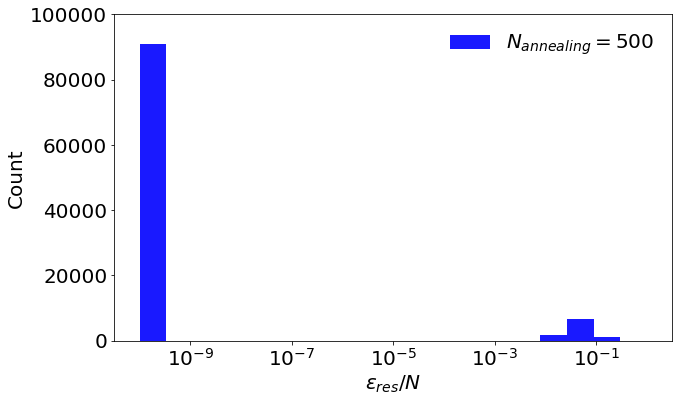

In [ ]:
MIN, MAX = 1e-10, 1.0
tol = 1e-10
gsenergy = -0.7307567000*Nx*Ny #Exact ground state energy obtained from spin glass server "https://software.cs.uni-koeln.de/spinglass/" for Nx,Ny = 5,5 and seed = 111
eres = ((energies - gsenergy)/N)
eres[eres<=0.0] = tol # eres<=0.0 might happen because of lack of numerical accuracy of the value of gsenergy given by spin-glass server

plt.figure(figsize = (10,6))
plt.hist(eres, alpha=0.9, color='b', bins = 10 ** np.linspace(np.log10(MIN), np.log10(MAX), 20), label='$N_{annealing}='+str(num_annealing_steps)+'$')

plt.gca().set_xscale("log")
plt.ylim(0, np.size(energies) )
plt.legend(loc='best', frameon=False)
plt.xlabel(r'$\epsilon_{res}/N$')
plt.ylabel('Count')
plt.show()